In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from __future__ import absolute_import

In [2]:
from extract_data import *
from finbeat_calc import *
from plot_track import *
from plot_accel import *
from check_plots import *
from plot_analysis import *
from make_subset import *
from read_data import *
from fourier_analysis import *
import pywt
import pylab
import numpy as np

plt.style.use('mystyle.mplstyle')

tracklist, finbeats, finbeat_byP, finbeat_byT = read_data('data.pickle')

In [3]:
bass_subset = make_subset(group_by1='species', identifier1='Bass', tracklist=tracklist)
bass_burst_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='B')
bass_steady_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='S')
bass_linacc_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='A')

trout_subset = make_subset(group_by1 = 'species', identifier1 ='BTrout', tracklist=tracklist)
trout_burst_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='B')
trout_steady_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='S')
trout_linacc_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='A')

In [12]:
finbeat_byP['Bass1S09']

,time,type,ypos,endtime,period,nxttrough,amplitude
1,0.184,P,17.222099,0.404,0.220,15.296162,1.925937
3,0.404,P,18.101099,0.667,0.263,16.048488,2.052610
5,0.667,P,16.922672,NaN,NaN,16.932210,0.009538
8,0.970,P,17.051890,NaN,NaN,17.055844,0.003954
11,1.157,P,17.537199,NaN,NaN,NaN,NaN


[ 0.367]
[ 0.96326818]
0.713368961606
2.72479564033


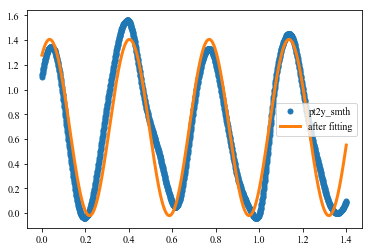

[ 0.264  0.27   0.28   0.28   0.288  0.288  0.294  0.306  0.312]
[ 1.91765268]
0.747165729441
3.48567002324


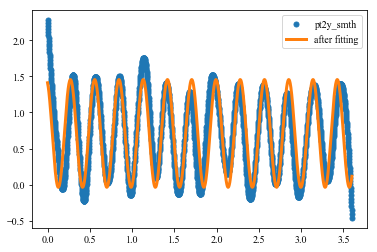

[ 0.246  0.272  0.282  0.282  0.292  0.33   0.342]
[ 1.07338822]
0.715717024772
3.42130987292


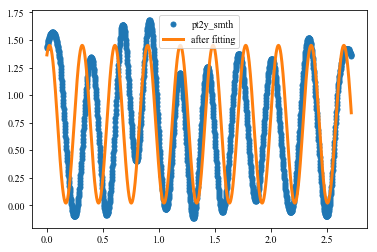

[ 0.18   0.182  0.188  0.196  0.2    0.2    0.204  0.204  0.206  0.208
  0.212  0.214  0.22 ]
[ 1.17806763]
0.616326858895
4.97322111706


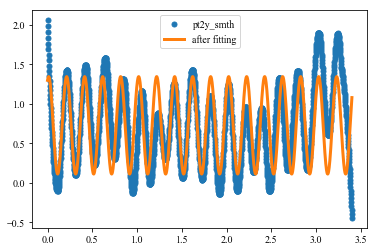

In [18]:
import peakutils
from scipy.optimize import leastsq
tracklist_subset = trout_linacc_subset

for trial in tracklist_subset:
    data = tracklist[trial]['data']['pt2y_smth']
    framerate = tracklist[trial]['FPS']
    base = peakutils.baseline(data, 3)  # Find linear bkgrd trend
    data = data - base
    time = tracklist[trial]['data'].index.values
    t=time
    periods = np.array(finbeat_byP[trial]['period'])
    #periods = np.append(amplitudes,
    #                       np.array(finbeat_byT[trial]['period']))
    periods = np.sort(periods)
    periods = periods[np.logical_not(np.isnan(periods))]
    periods = np.delete(periods, [0,len(periods)-1])
    period = np.mean(periods)
    print(periods)
    peak_frequency = 1./period
    
    amplitudes = np.array(finbeat_byP[trial]['amplitude'])
    amplitudes = np.append(amplitudes,
                           np.array(finbeat_byT[trial]['amplitude']))
    amplitudes = abs(amplitudes)
    amplitudes = np.sort(amplitudes)
    amplitudes = amplitudes[np.logical_not(np.isnan(amplitudes))]
    amplitudes = np.delete(amplitudes, [0,len(amplitudes)-1])
    amplitude = np.mean(amplitudes)/2
    guess_offset = np.mean(data)
    guess_phase = 0
    
    data_first_guess = amplitude*np.sin(2*np.pi*peak_frequency*t) + guess_offset
    
    optimize_func = lambda x: amplitude*np.sin(2*np.pi*peak_frequency*t+x[0]) + guess_offset - data
    est_phase = leastsq(optimize_func, [guess_phase])[0]

    
    data_fit = amplitude*np.sin(2*np.pi*peak_frequency*t + est_phase) + guess_offset
    print(est_phase)
    print(amplitude)
    print(peak_frequency)
 
    plt.plot(time,data, '.')
    plt.plot(time,data_fit, label='after fitting')
    plt.legend()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pywt 
from scipy import signal

testdata = tracklist['Bass1S09']['data']['pt2y_smth']
time = tracklist['Bass1S09']['data'].index.values
framerate = float(tracklist['Bass1S09']['FPS'])
scales = np.arange(2,20,1)


wavelet_choice = pywt.Wavelet('bior3.1')
print(wavelet_choice)
for i in np.arange(2,20,1):
    freq = pywt.scale2frequency(wavelet_choice, i)
    print(': scale=',i, ' freq=', freq)

In [ ]:
for name in pywt.wavelist(kind='discrete'):
    x = time
    data = testdata
    wavelet = name
    level = 1
    order = 'freq'
    interpolation = 'nearest'
    cmap = plt.cm.cool

    wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel = level)
    nodes = wp.get_level(level, order = order)
    labels = [n.path for n in nodes]
    values = np.array([n.data for n in nodes], 'd')
    values = abs(values)
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
    ax = fig.add_subplot(2, 1, 1)
    ax.set_title("Data")
    ax.plot(x, data, 'b')
    ax.set_xlim(0, x[-1])

    ax = fig.add_subplot(2, 1, 2)
    ax.set_title("Wavelet packet coefficients at level %d" % level)
    ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
              origin="lower", extent=[0, 1, 0, len(values)])
    ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

    # Show spectrogram and wavelet packet coefficients
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(211)
    ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
                 interpolation='bilinear')
    ax2.set_title("Spectrogram of signal")
    ax3 = fig2.add_subplot(212)
    ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
               interpolation='nearest')
    ax3.set_title("Wavelet packet coefficients")


    plt.show()



In [ ]:

import numpy as np
import matplotlib.pyplot as plt

import pywt


x = np.linspace(0, 1, num=512)
data = np.sin(250 * np.pi * x**2)

wavelet = 'db2'
level = 4
order = "freq"  # other option is "normal"
interpolation = 'nearest'
cmap = plt.cm.cool

# Construct wavelet packet
wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = np.array([n.data for n in nodes], 'd')
values = abs(values)

# Show signal and wavelet packet coefficients
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
ax = fig.add_subplot(2, 1, 1)
ax.set_title("linchirp signal")
ax.plot(x, data, 'b')
ax.set_xlim(0, x[-1])

ax = fig.add_subplot(2, 1, 2)
ax.set_title("Wavelet packet coefficients at level %d" % level)
ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
          origin="lower", extent=[0, 1, 0, len(values)])
ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

# Show spectrogram and wavelet packet coefficients
fig2 = plt.figure()
ax2 = fig2.add_subplot(211)
ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
             interpolation='bilinear')
ax2.set_title("Spectrogram of signal")
ax3 = fig2.add_subplot(212)
ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
           interpolation='nearest')
ax3.set_title("Wavelet packet coefficients")


plt.show()